In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib import learn
from sklearn import preprocessing
from sklearn import metrics
from __future__ import print_function
import itertools
#from tensorflow.python.ops import math_ops

%matplotlib inline

In [2]:
%run ./importWalkingDataConfidencev2.ipynb # with speed/gaitDuration feature..
tf.logging.set_verbosity(tf.logging.INFO)

Dimension of walking test_x  =  (134, 28)
Dimension of walking train_x =  (536, 28)


In [3]:
def get_input_fn(data_x,data_y, LABEL, num_epochs=None, shuffle=True):
  return tf.estimator.inputs.pandas_input_fn(
      x=pd.DataFrame({k: data_x[k].values for k in FEATURESALL_WTS}),
      y = pd.DataFrame(data_y[LABEL].values),
      num_epochs=num_epochs,
      shuffle=shuffle)

In [4]:
netSpeedBoundaries = np.arange(X_train_all_wts["netSpeed"].min(), X_train_all_wts["netSpeed"].max(), 0.5).tolist()
bodyAngBoundaries = np.arange(X_train_all_wts["bodyAngleZ"].min(), X_train_all_wts["bodyAngleZ"].max(), 0.5).tolist()

frontKBoundaries = np.arange(X_train_all_wts["frontKneesAngle"].min(), X_train_all_wts["frontKneesAngle"].max(), 0.25).tolist()
rearKBoundaries = np.arange(X_train_all_wts["rearKneesAngle"].min(), X_train_all_wts["rearKneesAngle"].max(), 0.25).tolist()

frontHBoundaries = np.arange(X_train_all_wts["frontHipsAngle"].min(), X_train_all_wts["frontHipsAngle"].max(), 0.25).tolist()
rearHBoundaries = np.arange(X_train_all_wts["rearHipsAngle"].min(), X_train_all_wts["rearHipsAngle"].max(), 0.25).tolist()

In [5]:
embedded_ffp_column = tf.contrib.layers.embedding_column(
    tf.contrib.layers.sparse_column_with_integerized_feature("FFPType", 7, combiner=None, dtype=tf.int64), dimension = 7)
sparse_ffp_column =  tf.contrib.layers.sparse_column_with_integerized_feature("FFPType", 7, combiner=None, dtype=tf.int64)
# Continuous columns- frontKneesAngle	rearKneesAngle	frontAnkle	rearAnkle	frontHipsAngle
bodyZ = tf.feature_column.numeric_column("bodyAngleZ")
frontK = tf.feature_column.numeric_column("frontKneesAngle")
rearK = tf.feature_column.numeric_column("rearKneesAngle")
frontA = tf.feature_column.numeric_column("frontAnkle")
rearA = tf.feature_column.numeric_column("rearAnkle")
frontH = tf.feature_column.numeric_column("frontHipsAngle")
rearH = tf.feature_column.numeric_column("rearHipsAngle")
swingFtHt = tf.feature_column.numeric_column("swingFtHeight")
speed = tf.feature_column.numeric_column("speed")
gaitTime = tf.feature_column.numeric_column("gaitDuration")
nSpeed = tf.feature_column.numeric_column("netSpeed")

nSpeedBucket = tf.feature_column.bucketized_column(nSpeed, boundaries=netSpeedBoundaries)
bodyAngBucket = tf.feature_column.bucketized_column(bodyZ, boundaries=bodyAngBoundaries)
frontKBucket = tf.feature_column.bucketized_column(frontK, boundaries=frontKBoundaries)
rearKBucket = tf.feature_column.bucketized_column(rearK, boundaries=rearKBoundaries)
frontHBucket = tf.feature_column.bucketized_column(frontH, boundaries=frontHBoundaries)
rearHBucket = tf.feature_column.bucketized_column(rearH, boundaries=rearHBoundaries)

xSpeedFFP = tf.feature_column.crossed_column([nSpeedBucket, sparse_ffp_column], hash_bucket_size = len(netSpeedBoundaries)*7)
xSpeedBodyAng = tf.feature_column.crossed_column([nSpeedBucket, bodyAngBucket], hash_bucket_size = len(bodyAngBoundaries)*len(netSpeedBoundaries))

xKnees = tf.feature_column.crossed_column([frontKBucket, rearKBucket], hash_bucket_size = len(frontKBoundaries)*len(rearKBoundaries))
xHips = tf.feature_column.crossed_column([frontHBucket, rearHBucket], hash_bucket_size = len(frontHBoundaries)*len(rearHBoundaries))

xKneeHip = tf.feature_column.crossed_column([xKnees,xHips], hash_bucket_size = len(frontKBoundaries)*len(rearKBoundaries)*len(frontHBoundaries)*len(rearHBoundaries))

feature_cols = [bodyZ, frontK, rearK, frontA, rearA, frontH, rearH, swingFtHt, speed, gaitTime, nSpeed, embedded_ffp_column]
#lin_feature_cols = [bodyZ, frontK, rearK, frontA, rearA, frontH, rearH, swingFtHt, speed, gaitTime]
#lin_feature_cols = [sparse_ffp_column]
#lin_feature_cols = [bodyZ, swingFtHt, speed, gaitTime, sparse_ffp_column]
# lin_feature_cols = [bodyZ, swingFtHt, speed, gaitTime, nSpeed, xSpeedFFP, xSpeedBodyAng]
#lin_feature_cols = [bodyZ, swingFtHt, speed, gaitTime, nSpeed, xSpeedBodyAng]
#lin_feature_cols = [bodyZ, swingFtHt, speed, gaitTime, xKnees, xHips]
lin_feature_cols = [bodyZ, swingFtHt, speed, gaitTime, nSpeed]
#lin_feature_cols = [bodyZ, swingFtHt, speed, gaitTime, nSpeed, xKneeHip]

In [6]:
LABEL_ID = 0;
LABEL = EMOSCORES[LABEL_ID]
WT_COL = WTS_LABEL[LABEL_ID]

In [7]:
# validation_metrics = {
#     "rmse":
#         tf.metrics.root_mean_squared_error(labels = pd.DataFrame(y_test[LABEL].values),predictions=y_predicted)
# }

In [8]:
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
input_fn=get_input_fn(X_test_all_wts, y_test, LABEL, num_epochs=1, shuffle=False),
    every_n_steps=50,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=500) #200 500 1000
    #metrics=validation_metrics)

Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.


In [9]:
# Build a wide + deep model
model_dir_name="/DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01"

# regressor = tf.contrib.learn.DNNLinearCombinedRegressor(linear_feature_columns = lin_feature_cols,
#   dnn_feature_columns=feature_cols, dnn_hidden_units=[1000],  model_dir=model_dir_name, weight_column_name = WT_COL,
#     dnn_optimizer = tf.train.AdamOptimizer(
#       learning_rate=0.01), dnn_dropout =0.1, config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1), dnn_activation_fn = tf.nn.softplus)

regressor = tf.contrib.learn.DNNLinearCombinedRegressor(linear_feature_columns = lin_feature_cols,
  dnn_feature_columns=feature_cols, dnn_hidden_units=[1000],  model_dir=model_dir_name, weight_column_name = WT_COL,
    dnn_optimizer = tf.train.AdamOptimizer(
      learning_rate=0.01), dnn_dropout =0.1, config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1), dnn_activation_fn = tf.nn.softplus)

# much slower training with one step fitting of linear and dnn when fix_global_step_increment_bug=True
#tf.contrib.layers.xavier_initializer(uniform=True) # this seems more useful for vision stuff where there is lot of fan_in and fan_out

Instructions for updating:
Please set fix_global_step_increment_bug=True and update training steps in your pipeline. See pydoc for details.
INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_evaluation_master': '', '_save_checkpoints_steps': None, '_task_type': None, '_keep_checkpoint_max': 5, '_environment': 'local', '_is_chief': True, '_num_worker_replicas': 0, '_save_checkpoints_secs': 1, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_num_ps_replicas': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000026E5B23AD30>, '_model_dir': '/DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01', '_master': '', '_log_step_count_steps': 100, '_save_summary_steps': 100, '_task_id': 0, '_session_config': None, '_tf_random_seed': None}


In [10]:
# Train.
regressor.fit(input_fn=get_input_fn(X_train_all_wts, y_train, LABEL, num_epochs=None, shuffle=True),steps=200000, monitors=[validation_monitor]) #2000000

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 2 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:step = 2, loss = 424.797
INFO:tensorflow:Saving checkpoints for 4 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 6 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 8 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 10 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 12 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_Confidenc

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-52
INFO:tensorflow:Finished evaluation at 2017-10-02-18:36:01
INFO:tensorflow:Saving dict for global step 52: global_step = 52, loss = 17.7593
INFO:tensorflow:Validation (step 51): global_step = 52, loss = 17.7593
INFO:tensorflow:Saving checkpoints for 54 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 56 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 58 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 60 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01Ear

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-102
INFO:tensorflow:Finished evaluation at 2017-10-02-18:36:30
INFO:tensorflow:Saving dict for global step 102: global_step = 102, loss = 22.2433
INFO:tensorflow:Validation (step 101): global_step = 102, loss = 22.2433
INFO:tensorflow:Saving checkpoints for 104 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 106 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 108 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 110 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDro

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-152
INFO:tensorflow:Finished evaluation at 2017-10-02-18:36:58
INFO:tensorflow:Saving dict for global step 152: global_step = 152, loss = 14.2472
INFO:tensorflow:Validation (step 151): global_step = 152, loss = 14.2472
INFO:tensorflow:Saving checkpoints for 154 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 156 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 158 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 160 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDro

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-202
INFO:tensorflow:Finished evaluation at 2017-10-02-18:37:26
INFO:tensorflow:Saving dict for global step 202: global_step = 202, loss = 14.3943
INFO:tensorflow:Validation (step 201): global_step = 202, loss = 14.3943
INFO:tensorflow:step = 202, loss = 10.6551 (113.282 sec)
INFO:tensorflow:Saving checkpoints for 204 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 206 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 208 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 210 into /DNN/wideAndDeep/wideMotion

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-252
INFO:tensorflow:Finished evaluation at 2017-10-02-18:37:54
INFO:tensorflow:Saving dict for global step 252: global_step = 252, loss = 17.1985
INFO:tensorflow:Validation (step 251): global_step = 252, loss = 17.1985
INFO:tensorflow:Saving checkpoints for 254 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 256 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 258 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 260 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDro

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-302
INFO:tensorflow:Finished evaluation at 2017-10-02-18:38:22
INFO:tensorflow:Saving dict for global step 302: global_step = 302, loss = 14.8863
INFO:tensorflow:Validation (step 301): global_step = 302, loss = 14.8863
INFO:tensorflow:Saving checkpoints for 304 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 306 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 308 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 310 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDro

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-352
INFO:tensorflow:Finished evaluation at 2017-10-02-18:38:50
INFO:tensorflow:Saving dict for global step 352: global_step = 352, loss = 15.063
INFO:tensorflow:Validation (step 351): global_step = 352, loss = 15.063
INFO:tensorflow:Saving checkpoints for 354 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 356 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 358 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 360 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropo

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-402
INFO:tensorflow:Finished evaluation at 2017-10-02-18:39:17
INFO:tensorflow:Saving dict for global step 402: global_step = 402, loss = 14.0256
INFO:tensorflow:Validation (step 401): global_step = 402, loss = 14.0256
INFO:tensorflow:step = 402, loss = 11.1433 (110.737 sec)
INFO:tensorflow:Saving checkpoints for 404 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 406 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 408 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 410 into /DNN/wideAndDeep/wideMotion

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-452
INFO:tensorflow:Finished evaluation at 2017-10-02-18:39:45
INFO:tensorflow:Saving dict for global step 452: global_step = 452, loss = 14.0842
INFO:tensorflow:Validation (step 451): global_step = 452, loss = 14.0842
INFO:tensorflow:Saving checkpoints for 454 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 456 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 458 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 460 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDro

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-502
INFO:tensorflow:Finished evaluation at 2017-10-02-18:40:13
INFO:tensorflow:Saving dict for global step 502: global_step = 502, loss = 15.2721
INFO:tensorflow:Validation (step 501): global_step = 502, loss = 15.2721
INFO:tensorflow:Saving checkpoints for 504 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 506 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 508 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 510 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDro

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-552
INFO:tensorflow:Finished evaluation at 2017-10-02-18:40:42
INFO:tensorflow:Saving dict for global step 552: global_step = 552, loss = 14.8136
INFO:tensorflow:Validation (step 551): global_step = 552, loss = 14.8136
INFO:tensorflow:Saving checkpoints for 554 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 556 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 558 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 560 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDro

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-602
INFO:tensorflow:Finished evaluation at 2017-10-02-18:41:10
INFO:tensorflow:Saving dict for global step 602: global_step = 602, loss = 16.0536
INFO:tensorflow:Validation (step 601): global_step = 602, loss = 16.0536
INFO:tensorflow:step = 602, loss = 9.02275 (113.191 sec)
INFO:tensorflow:Saving checkpoints for 604 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 606 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 608 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 610 into /DNN/wideAndDeep/wideMotion

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-652
INFO:tensorflow:Finished evaluation at 2017-10-02-18:41:38
INFO:tensorflow:Saving dict for global step 652: global_step = 652, loss = 15.0525
INFO:tensorflow:Validation (step 651): global_step = 652, loss = 15.0525
INFO:tensorflow:Saving checkpoints for 654 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 656 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 658 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 660 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDro

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-702
INFO:tensorflow:Finished evaluation at 2017-10-02-18:42:06
INFO:tensorflow:Saving dict for global step 702: global_step = 702, loss = 13.4947
INFO:tensorflow:Validation (step 701): global_step = 702, loss = 13.4947
INFO:tensorflow:Saving checkpoints for 704 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 706 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 708 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 710 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDro

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-752
INFO:tensorflow:Finished evaluation at 2017-10-02-18:42:34
INFO:tensorflow:Saving dict for global step 752: global_step = 752, loss = 16.2399
INFO:tensorflow:Validation (step 751): global_step = 752, loss = 16.2399
INFO:tensorflow:Saving checkpoints for 754 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 756 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 758 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 760 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDro

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-802
INFO:tensorflow:Finished evaluation at 2017-10-02-18:43:02
INFO:tensorflow:Saving dict for global step 802: global_step = 802, loss = 14.1
INFO:tensorflow:Validation (step 801): global_step = 802, loss = 14.1
INFO:tensorflow:step = 802, loss = 9.2668 (111.808 sec)
INFO:tensorflow:Saving checkpoints for 804 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 806 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 808 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 810 into /DNN/wideAndDeep/wideMotionBodyAng

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-852
INFO:tensorflow:Finished evaluation at 2017-10-02-18:43:30
INFO:tensorflow:Saving dict for global step 852: global_step = 852, loss = 13.9946
INFO:tensorflow:Validation (step 851): global_step = 852, loss = 13.9946
INFO:tensorflow:Saving checkpoints for 854 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 856 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 858 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 860 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDro

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-10-02-18:43:57
INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-902
INFO:tensorflow:Finished evaluation at 2017-10-02-18:43:58
INFO:tensorflow:Saving dict for global step 902: global_step = 902, loss = 13.3447
INFO:tensorflow:Validation (step 901): global_step = 902, loss = 13.3447
INFO:tensorflow:Saving checkpoints for 904 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 906 into /DNN/wideAndDeep/wideMot

  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\contrib\learn\python\learn\estimators\head.py", line 637, in _create_model_fn_ops
    weight_tensor = _weight_tensor(features, weight_column_name)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\contrib\learn\python\learn\estimators\head.py", line 1760, in _weight_tensor
    weight_column_name, shape)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\platform\tf_logging.py", line 90, in warning
    _logger.warning(msg, *args, **kwargs)
Message: 'Weights {} has shape {}, expanding to make it 2d.'
Arguments: ('happier_wt', TensorShape([Dimension(None)]))
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Use

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-952
INFO:tensorflow:Finished evaluation at 2017-10-02-18:44:26
INFO:tensorflow:Saving dict for global step 952: global_step = 952, loss = 18.4195
INFO:tensorflow:Validation (step 951): global_step = 952, loss = 18.4195
INFO:tensorflow:Saving checkpoints for 954 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 956 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 958 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 960 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDro

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-1002
INFO:tensorflow:Finished evaluation at 2017-10-02-18:44:53
INFO:tensorflow:Saving dict for global step 1002: global_step = 1002, loss = 14.1185
INFO:tensorflow:Validation (step 1001): global_step = 1002, loss = 14.1185
INFO:tensorflow:step = 1002, loss = 9.61624 (111.576 sec)
INFO:tensorflow:Saving checkpoints for 1004 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1006 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1008 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1010 into /DNN/wideAndDeep/

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-1052
INFO:tensorflow:Finished evaluation at 2017-10-02-18:45:21
INFO:tensorflow:Saving dict for global step 1052: global_step = 1052, loss = 17.4891
INFO:tensorflow:Validation (step 1051): global_step = 1052, loss = 17.4891
INFO:tensorflow:Saving checkpoints for 1054 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1056 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1058 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1060 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer100

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-1102
INFO:tensorflow:Finished evaluation at 2017-10-02-18:45:49
INFO:tensorflow:Saving dict for global step 1102: global_step = 1102, loss = 14.9588
INFO:tensorflow:Validation (step 1101): global_step = 1102, loss = 14.9588
INFO:tensorflow:Saving checkpoints for 1104 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1106 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1108 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1110 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer100

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-1152
INFO:tensorflow:Finished evaluation at 2017-10-02-18:46:17
INFO:tensorflow:Saving dict for global step 1152: global_step = 1152, loss = 15.0428
INFO:tensorflow:Validation (step 1151): global_step = 1152, loss = 15.0428
INFO:tensorflow:Saving checkpoints for 1154 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1156 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1158 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1160 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer100

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-1202
INFO:tensorflow:Finished evaluation at 2017-10-02-18:46:45
INFO:tensorflow:Saving dict for global step 1202: global_step = 1202, loss = 15.1825
INFO:tensorflow:Validation (step 1201): global_step = 1202, loss = 15.1825
INFO:tensorflow:step = 1202, loss = 9.51676 (111.927 sec)
INFO:tensorflow:Saving checkpoints for 1204 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1206 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1208 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1210 into /DNN/wideAndDeep/

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-1252
INFO:tensorflow:Finished evaluation at 2017-10-02-18:47:13
INFO:tensorflow:Saving dict for global step 1252: global_step = 1252, loss = 18.84
INFO:tensorflow:Validation (step 1251): global_step = 1252, loss = 18.84
INFO:tensorflow:Saving checkpoints for 1254 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1256 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1258 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1260 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000Uni

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-1302
INFO:tensorflow:Finished evaluation at 2017-10-02-18:47:42
INFO:tensorflow:Saving dict for global step 1302: global_step = 1302, loss = 15.0993
INFO:tensorflow:Validation (step 1301): global_step = 1302, loss = 15.0993
INFO:tensorflow:Saving checkpoints for 1304 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1306 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1308 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1310 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer100

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-1352
INFO:tensorflow:Finished evaluation at 2017-10-02-18:48:09
INFO:tensorflow:Saving dict for global step 1352: global_step = 1352, loss = 16.616
INFO:tensorflow:Validation (step 1351): global_step = 1352, loss = 16.616
INFO:tensorflow:Saving checkpoints for 1354 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1356 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1358 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1360 into /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000U

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-10-02-18:48:37
INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-1402
INFO:tensorflow:Finished evaluation at 2017-10-02-18:48:38
INFO:tensorflow:Saving dict for global step 1402: global_step = 1402, loss = 15.5578
INFO:tensorflow:Validation (step 1401): global_step = 1402, loss = 15.5578
INFO:tensorflow:Stopping. Best step: 901 with loss = 13.344711303710938.
INFO:tensorflow:step = 1402, loss = 8.34821 (112.345 sec)
INFO:tensorflow:Loss for final step: 8.34821.


  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\contrib\learn\python\learn\estimators\head.py", line 732, in create_model_fn_ops
    enable_centered_bias=self._enable_centered_bias)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\contrib\learn\python\learn\estimators\head.py", line 637, in _create_model_fn_ops
    weight_tensor = _weight_tensor(features, weight_column_name)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\contrib\learn\python\learn\estimators\head.py", line 1760, in _weight_tensor
    weight_column_name, shape)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\platform\tf_logging.py", line 90, in warning
    _logger.warning(msg, *args, **kwargs)
Message: 'Weights {} has shape {}, expanding to make it 2d.'
Arguments: ('happier_wt', TensorShape([D

DNNLinearCombinedRegressor(params={'fix_global_step_increment_bug': False, 'joint_linear_weights': False, 'dnn_feature_columns': [_NumericColumn(key='bodyAngleZ', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='frontKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='rearKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='frontAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='rearAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='frontHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='rearHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='swingFtHeight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='

In [11]:
 ev = regressor.evaluate(
     input_fn=get_input_fn(X_test_all_wts, y_test, LABEL, num_epochs=1, shuffle=False))#,metrics=validation_metrics)
print('MSE (tensorflow): {0:f}'.format(ev['loss']))

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-10-02-18:48:38


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-1402
INFO:tensorflow:Finished evaluation at 2017-10-02-18:48:39
INFO:tensorflow:Saving dict for global step 1402: global_step = 1402, loss = 15.5578
MSE (tensorflow): 15.557814


In [12]:
predictions = regressor.predict_scores(input_fn=get_input_fn(X_test_all_wts, y_test, LABEL, num_epochs=1, shuffle=False))
y_predicted = list(itertools.islice(predictions,y_test[LABEL].size))

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-1402


In [13]:
y_predicted

[30.659668,
 21.896828,
 25.355124,
 24.335249,
 29.557247,
 32.602463,
 20.161079,
 21.464872,
 31.524197,
 30.961933,
 24.177782,
 19.458313,
 23.68153,
 21.969013,
 22.748713,
 23.871468,
 24.031984,
 25.249441,
 22.401463,
 32.064888,
 22.408577,
 23.703802,
 26.610573,
 33.084042,
 25.543652,
 22.854073,
 24.813873,
 23.124014,
 20.6019,
 30.681648,
 20.628614,
 23.59079,
 23.603666,
 26.463337,
 34.380798,
 24.706142,
 23.768835,
 31.599766,
 30.227032,
 28.96295,
 31.154322,
 24.725603,
 20.752132,
 24.377502,
 25.246857,
 30.166641,
 23.09774,
 35.532299,
 21.137472,
 25.50065,
 26.895378,
 28.745264,
 26.847076,
 27.145245,
 21.111912,
 21.421913,
 24.05827,
 23.013618,
 25.018578,
 21.164358,
 25.167786,
 22.517263,
 20.065901,
 24.940977,
 23.927061,
 30.884062,
 31.313351,
 19.743715,
 27.318832,
 27.221601,
 23.917013,
 30.037983,
 29.715065,
 33.047779,
 24.888954,
 23.862352,
 25.023872,
 20.075539,
 34.675915,
 24.162024,
 25.277748,
 19.50029,
 26.984129,
 28.443783,
 

In [14]:
# Score with sklearn.
score_sklearn = metrics.mean_squared_error(y_test[LABEL].values,y_predicted)
print('MSE (sklearn): {0:f}'.format(score_sklearn))
r2_score = metrics.r2_score(y_test[LABEL].values, y_predicted)
print('R2 (sklearn): {0:f}'.format(r2_score))
# Score with sklearn.
score_sklearn_wtd = metrics.mean_squared_error(y_test[LABEL].values,y_predicted,sample_weight=X_test_all_wts[WT_COL].values)
print('MSE WTD (sklearn): {0:f}'.format(score_sklearn_wtd))
r2_score_wtd = metrics.r2_score(y_test[LABEL].values, y_predicted, sample_weight=X_test_all_wts[WT_COL].values)
print('R2 WTD (sklearn): {0:f}'.format(r2_score_wtd))

MSE (sklearn): 19.195601
R2 (sklearn): 0.433358
MSE WTD (sklearn): 18.010546
R2 WTD (sklearn): 0.491890


In [15]:
y_hat = pd.DataFrame(y_predicted, columns=["predicted_happy"], index=y_test[LABEL].index) 

In [16]:
y_all = pd.concat([y_hat, y_test[LABEL], y_test["happier_sigma"], y_test["gif_id"]], axis=1) #gif id is only for debuggingK

In [17]:
y_all_sorted = y_all.sort_values("happier_mu",ascending=[True])

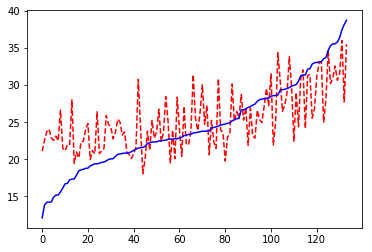

In [18]:
plt.figure()
plt.plot(y_all_sorted["predicted_happy"].values,'r--',y_all_sorted[LABEL].values,'b')

In [19]:
regressor.get_params()

{'params': {'dnn_activation_fn': <function tensorflow.python.ops.gen_nn_ops.softplus>,
  'dnn_dropout': 0.1,
  'dnn_feature_columns': [_NumericColumn(key='bodyAngleZ', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='frontKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='rearKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='frontAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='rearAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='frontHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='rearHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='swingFtHeight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=N

In [20]:
ev_train = regressor.evaluate(
     input_fn=get_input_fn(X_train_all_wts, y_train, LABEL, num_epochs=1, shuffle=False))#,metrics=validation_metrics)
print('MSE train (tensorflow): {0:f}'.format(ev_train['loss']))
train_predictions = regressor.predict_scores(input_fn=get_input_fn(X_train_all_wts, y_train, LABEL, num_epochs=1, shuffle=False))
y_predicted_train = list(itertools.islice(train_predictions,y_train[LABEL].size))

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-10-02-18:48:42


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-1402
INFO:tensorflow:Finished evaluation at 2017-10-02-18:48:42
INFO:tensorflow:Saving dict for global step 1402: global_step = 1402, loss = 17.3392
MSE train (tensorflow): 17.339245
INFO:tensorflow:Restoring parameters from /DNN/wideAndDeep/wideMotionBodyAngNSpeedDeepAll_ConfidenceSoftplus1Layer1000UnitsDropout01EarlyStopLR01\model.ckpt-1402


In [21]:
# Score with sklearn.
score_sklearn_train = metrics.mean_squared_error(y_train[LABEL].values,y_predicted_train)
print('MSE train (sklearn): {0:f}'.format(score_sklearn_train))
r2_score_train = metrics.r2_score(y_train[LABEL].values, y_predicted_train)
print('R2 train (sklearn): {0:f}'.format(r2_score_train))
# Score with sklearn.
score_sklearn_wtd_train = metrics.mean_squared_error(y_train[LABEL].values,y_predicted_train,sample_weight=X_train_all_wts[WT_COL].values)
print('MSE WTD train (sklearn): {0:f}'.format(score_sklearn_wtd_train))
r2_score_wtd_train = metrics.r2_score(y_train[LABEL].values, y_predicted_train, sample_weight=X_train_all_wts[WT_COL].values)
print('R2 WTD train (sklearn): {0:f}'.format(r2_score_wtd_train))

MSE train (sklearn): 18.337317
R2 train (sklearn): 0.491467
MSE WTD train (sklearn): 16.939648
R2 WTD train (sklearn): 0.543394


Populating the interactive namespace from numpy and matplotlib


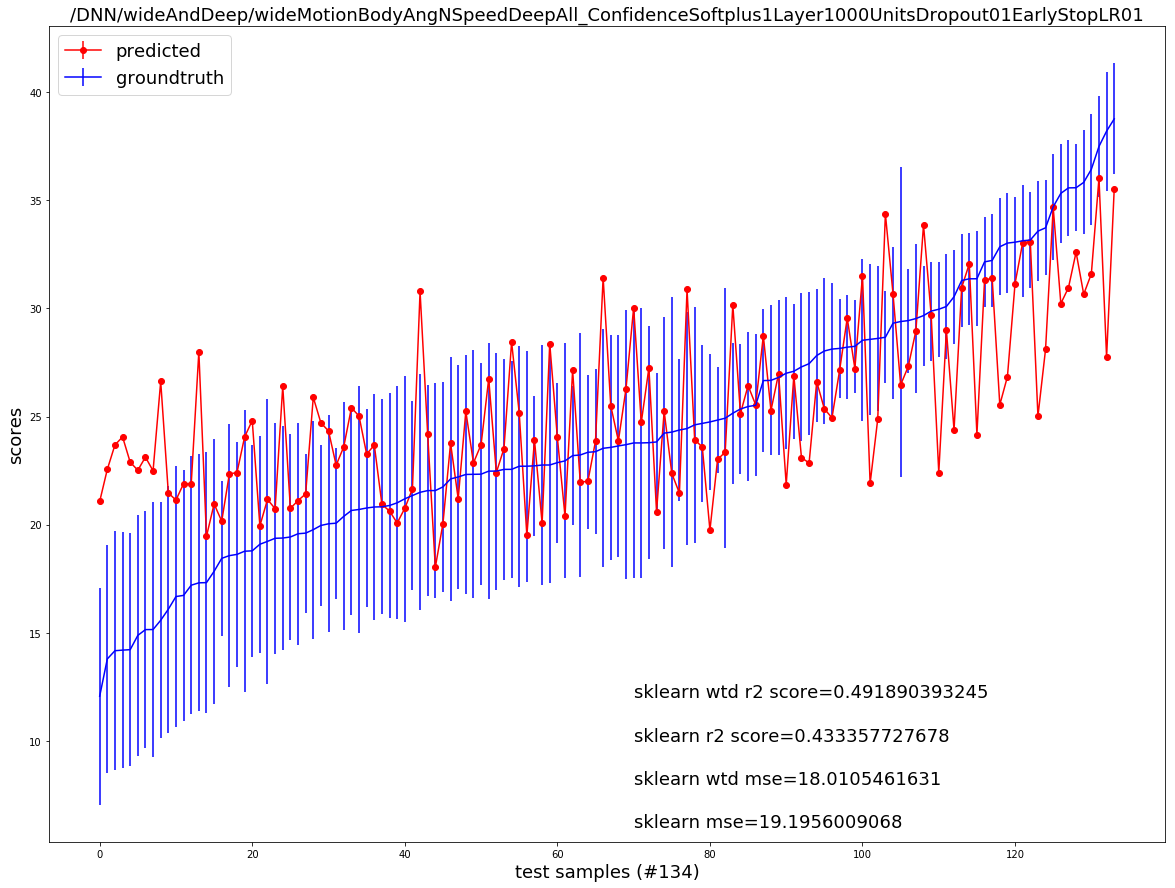

In [22]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_sorted["predicted_happy"].size, 1)
plt.errorbar(x,y_all_sorted["predicted_happy"].values,yerr=0,fmt='r-o',label="predicted")
plt.errorbar(x,y_all_sorted[LABEL].values,yerr=y_all_sorted["happier_sigma"],fmt='b',label="groundtruth")
plt.title(model_dir_name,fontsize=18)
plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
plt.ylabel('scores',fontsize=18)
pylab.legend(loc='upper left', fontsize=18)
plt.text(70,12, 'sklearn wtd r2 score='+str(r2_score_wtd), fontsize=18)
plt.text(70,10, 'sklearn r2 score='+str(r2_score), fontsize=18)
plt.text(70,8, 'sklearn wtd mse='+str(score_sklearn_wtd), fontsize=18)
plt.text(70,6, 'sklearn mse='+str(score_sklearn), fontsize=18)
plt.show()
fig_name = model_dir_name + "/testPrediction.pdf"
ax.savefig(fig_name) 

In [23]:
y_hat_train = pd.DataFrame(y_predicted_train, columns=["predicted_happy_train"], index=y_train[LABEL].index) 
y_all_train = pd.concat([y_hat_train, y_train[LABEL], y_train["happier_sigma"], y_train["gif_id"]], axis=1) #gif id is only for debugging
y_all_sorted_train = y_all_train.sort_values("happier_mu",ascending=[True])

Populating the interactive namespace from numpy and matplotlib


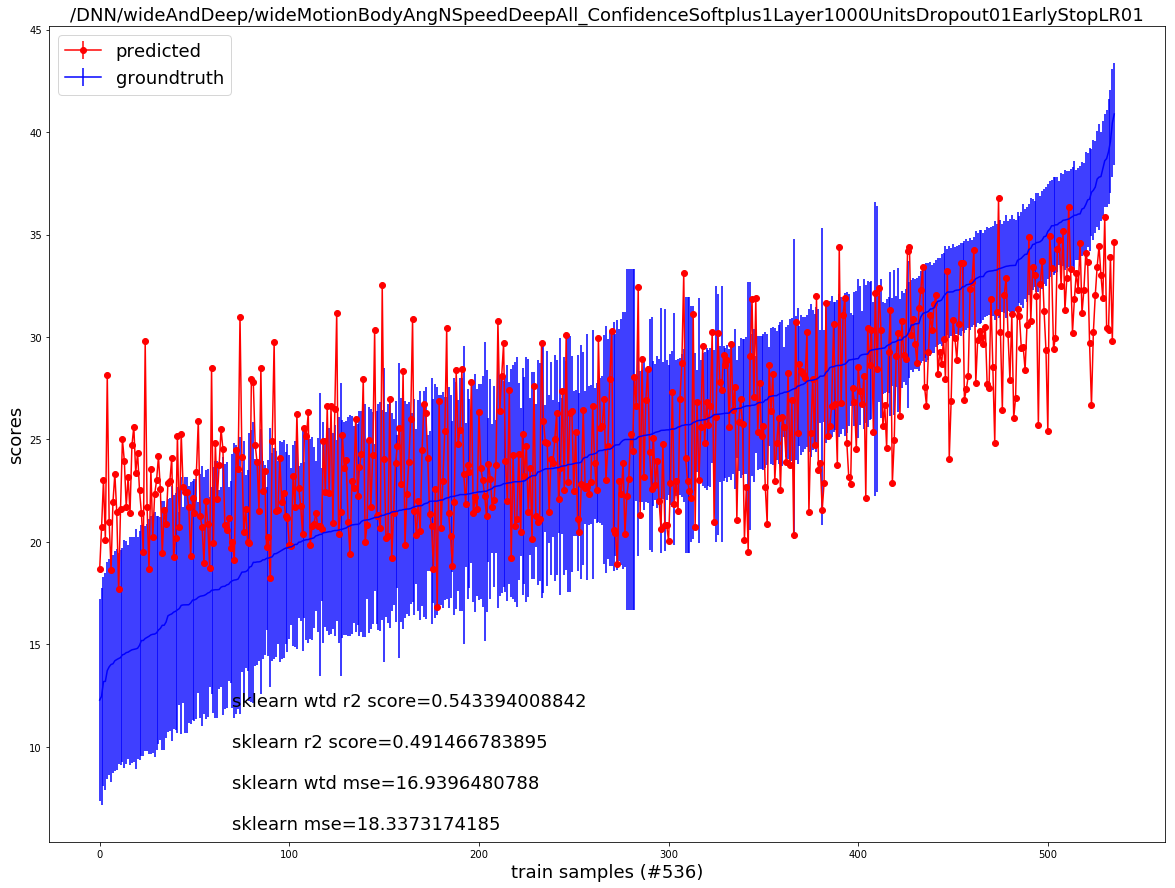

In [24]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_sorted_train["predicted_happy_train"].size, 1)
plt.errorbar(x,y_all_sorted_train["predicted_happy_train"].values,yerr=0,fmt='r-o',label="predicted")
plt.errorbar(x,y_all_sorted_train[LABEL].values,yerr=y_all_sorted_train["happier_sigma"],fmt='b',label="groundtruth")
plt.title(model_dir_name,fontsize=18)
plt.xlabel('train samples (#'+str(y_train[LABEL].size)+')',fontsize=18)
plt.ylabel('scores',fontsize=18)
pylab.legend(loc='upper left', fontsize=18)
plt.text(70,12, 'sklearn wtd r2 score='+str(r2_score_wtd_train), fontsize=18)
plt.text(70,10, 'sklearn r2 score='+str(r2_score_train), fontsize=18)
plt.text(70,8, 'sklearn wtd mse='+str(score_sklearn_wtd_train), fontsize=18)
plt.text(70,6, 'sklearn mse='+str(score_sklearn_train), fontsize=18)
plt.show()
fig_name = model_dir_name + "/trainPrediction.pdf"
ax.savefig(fig_name) 